# Momentum distributions

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ May 30, 2023

Plots single-nucleon momentum distributions which are calculated using SRG-evolved momentum projection operators with low-resolution nuclear wavefunctions approximated as a single Slater determinant of Woods-Saxon single-particle orbitals.

_Last update:_ October 24, 2023

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# Imports from scripts
from scripts.figures import (
    label_kvnn, label_lambda, label_nucleus, set_rc_parameters
)
from scripts.tools import replace_periods

from test_momentum_distribution_script import load_momentum_distribution
from test_momentum_distribution_script import compute_normalization

### Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
# Save figures in the following directory
figures_directory = '../figures/momentum_distributions/'
vmc_directory = '../data/vmc/momentum_distributions/'

## Comparison to VMC

In [5]:
def single_nucleon_momentum_distributions_multipanel(
        nuclei, nucleon, kvnn, lamb, x_limits=(0.0,6.0), y_limits=(1e-4,1e3),
        y_scale='log', show_vmc=False, save=False
):
    """Plot a single-nucleon momentum distribution with several built-in
    options.
    """
    
    # Initialize figure
    plt.close('all')
    row_number, col_number = 1, len(nuclei)
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number, 4*row_number))
        
    # Loop over nuclei
    for i, nucleus in enumerate(nuclei):
        
        nucleus_name, Z, N = nucleus
        if nucleon == 'proton':
            factor = Z
        elif nucleon == 'neutron':
            factor = N
            
        if y_scale == 'log':
            axs[i].set_yscale('log')
        else:
            axs[i].set_yscale('linear')
        
        # Compare to VMC calculation?
        if show_vmc:
        
            file_name = f"{nucleus_name}_single_nucleon.txt"
            data = np.loadtxt(vmc_directory + file_name)
            q_array_vmc = data[:,0]
            n_array_vmc = data[:,1] / factor
            n_errors_vmc = data[:,2] / factor
        
            if y_scale == 'linear':
            
                axs[i].errorbar(
                    q_array_vmc, n_array_vmc * q_array_vmc ** 2 ,
                    yerr=n_errors_vmc, color='black', label='VMC', linestyle='',
                    marker='.', zorder=3
                )
            
            else:
            
                axs[i].errorbar(
                    q_array_vmc, n_array_vmc, yerr=n_errors_vmc, color='black',
                    label='VMC', linestyle='', marker='.', zorder=3
                )

        # Load data from file
        q_array, q_weights, n_array, n_errors, n_ipm_array, _, _, _, _ = (
            load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb)
        )
    
        # Multiply by factor (2\pi)^3 / Z (N) to compare to VMC data
        n_array *= (2*np.pi) ** 3 / factor
        n_errors *= (2*np.pi) ** 3 / factor
        n_ipm_array *= (2*np.pi) ** 3 / factor

        # Add to plot
        if y_scale == 'linear':
        
            axs[i].plot(
                q_array, n_array * q_array ** 2,
                label='SRG', linewidth=2.0, zorder=2
            )
            
            axs[i].plot(q_array, n_ipm_array * q_array ** 2, label='IPM',
                        linestyle='dotted', linewidth=2.0, zorder=1)

        else:
        
            axs[i].plot(q_array, n_array, label='SRG', linewidth=2.0, zorder=2)
            
            axs[i].plot(q_array, n_ipm_array, label='IPM', linestyle='dotted',
                        linewidth=2.0, zorder=1)

        # Set axes limits
        axs[i].set_xlim(x_limits)
        axs[i].set_ylim(y_limits)

        # Set axes labels
        axs[i].set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
        if i == 0:  # First column only
            if y_scale == 'linear' and nucleon == 'proton':
                ylabel = r"$q^2 n_{p}(q)/Z$ [fm]"
            elif y_scale == 'linear' and nucleon == 'neutron':
                ylabel = r"$q^2 n_{n}(q)/N$ [fm]"
            elif y_scale == 'log' and nucleon == 'proton':
                ylabel = r"$n_{p}(q)/Z$ [fm" + r'$^3$' + ']'
            elif y_scale == 'log' and nucleon == 'neutron':
                ylabel = r"$n_{n}(q)/N$ [fm" + r'$^3$' + ']'
            axs[i].set_ylabel(ylabel, fontsize=16)

        # Add nucleus label
        if y_scale == 'log':
            nucleus_label_loc = 'lower left'
        elif y_scale == 'linear':
            nucleus_label_loc = 'upper left'
        axs[i].add_artist(
            AnchoredText(label_nucleus(nucleus_name), loc=nucleus_label_loc,
                         prop=dict(size=18), frameon=False)
        )
        
    # Set legend in first panel only
    axs[0].legend(loc='upper right', fontsize=16, frameon=False)
    
    # Add \lambda label in last panel
    axs[-1].add_artist(
        AnchoredText(label_lambda(lamb), loc='upper right', prop=dict(size=18),
                     frameon=False)
    )
        
    # Amount of white space in-between sub-plots
    f.subplots_adjust(wspace=0.1)

    # Save?
    if save:   
        file_name = replace_periods(
            f"{nucleon}_momentum_distributions_kvnn_{kvnn}_lamb_{lamb}"
            f"_{y_scale}_scale"
        )
        f.savefig(figures_directory + file_name + '.png')

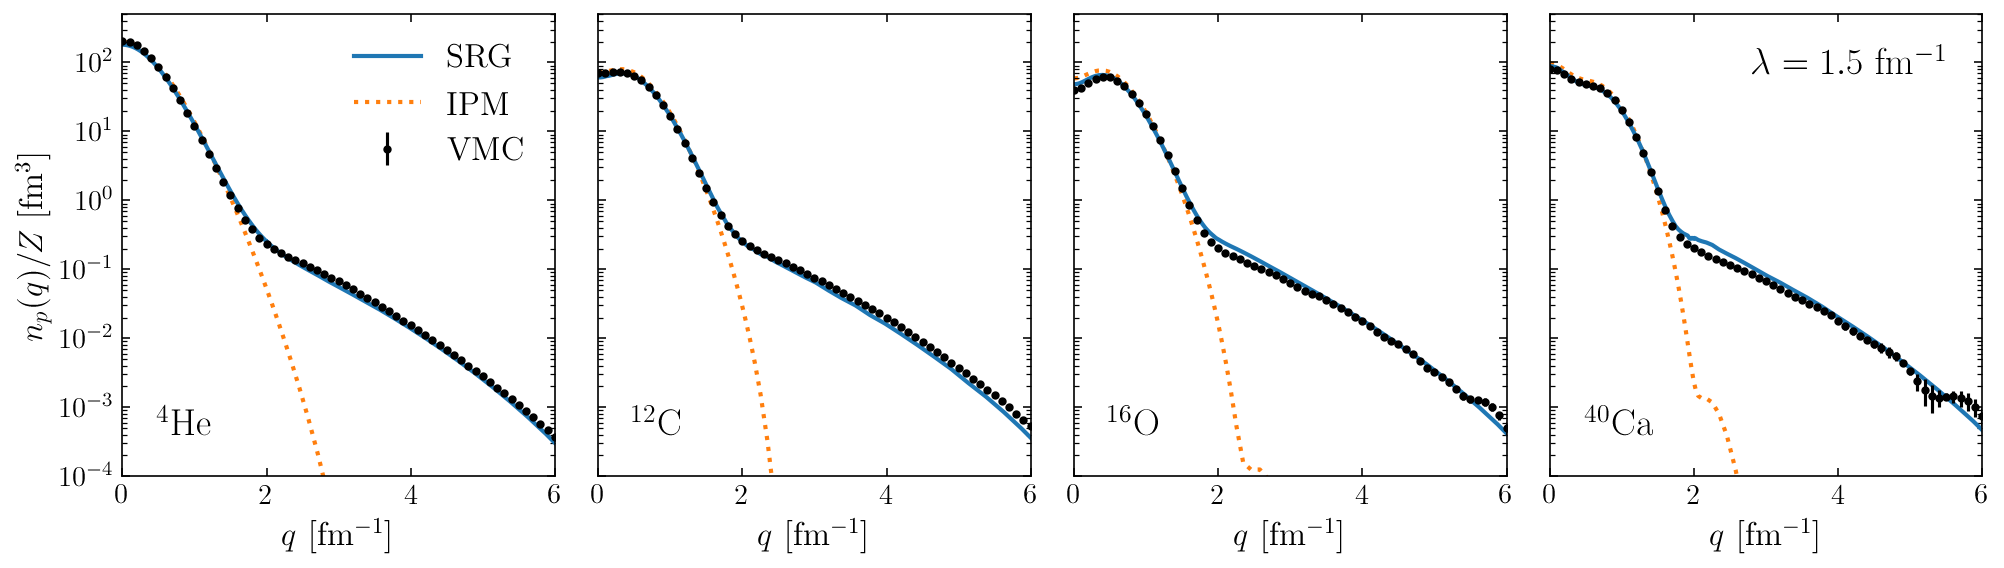

In [6]:
# \lambda = 1.5 fm^-1 log y scale

nuclei = (('He4', 2, 2), ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20))

single_nucleon_momentum_distributions_multipanel(
    nuclei, 'proton', 6, 1.5, y_limits=(1e-4, 5e2), show_vmc=True, save=True
)

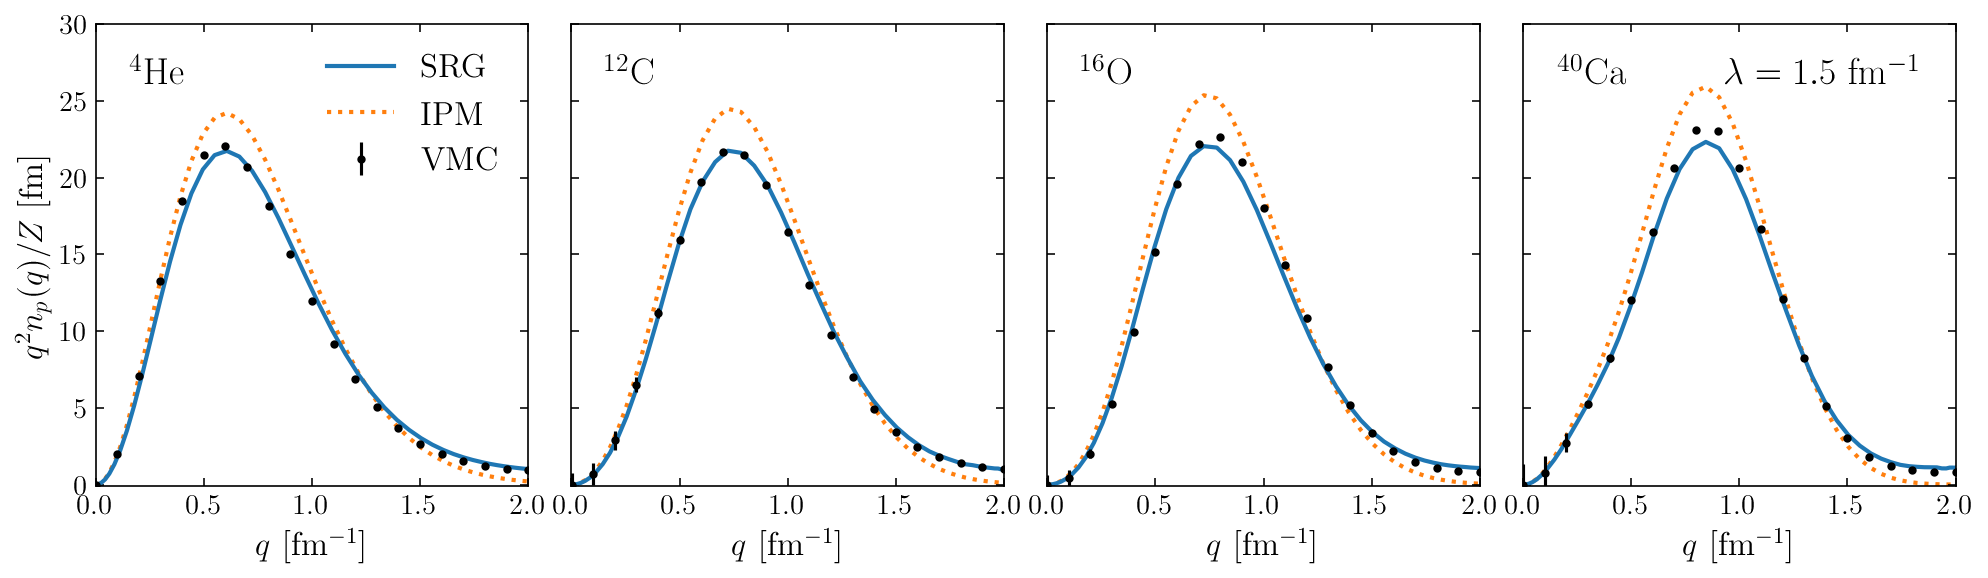

In [7]:
# \lambda = 1.5 fm^-1 linear y scale

nuclei = (('He4', 2, 2), ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20))

single_nucleon_momentum_distributions_multipanel(
    nuclei, 'proton', 6, 1.5, x_limits=(0.0, 2.0), y_limits=(-0.1, 30),
    y_scale='linear', show_vmc=True, save=True
)

## Contributions of single-nucleon momentum distribution

In [8]:
def single_nucleon_momentum_distribution_contributions(
        nucleus_name, nucleon, kvnn, lamb, number_of_curves=4,
        x_limits=(0.0,6.0), y_limits=(9e-6,1e3), print_normalization=False,
        save=False
):
    """Plots momentum distributions showing I, \delta U + \delta U^\dagger, and
    \delta U \delta U^\dagger contributions.
    """
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))

    # Load data from file
    (q_array, q_weights, n_array, _, n_I_array, n_delU_array, _, n_delU2_array,
     _) = load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb)
    
    # Print normalization?
    if print_normalization:

        total_norm = compute_normalization(q_array, q_weights, n_array)
        print(f"Total normalization = {total_norm}.")
        
        I_norm = compute_normalization(q_array, q_weights, n_I_array)
        print(f"I normalization = {I_norm}.")
        
        delU_norm = compute_normalization(q_array, q_weights, n_delU_array)
        print(f"\delta U + \delta U^\dagger normalization = {delU_norm}.")
        
        delU2_norm = compute_normalization(q_array, q_weights, n_delU2_array)
        print(f"\delta U \delta U^\dagger normalization = {delU2_norm}.")
        
        relative_error = np.abs(delU_norm + delU2_norm) / delU2_norm * 100
        print(f"Relative error = {relative_error}%.")
    
    # Multiply by factor (2\pi)^3
    n_array *= (2*np.pi) ** 3
    n_I_array *= (2*np.pi) ** 3
    n_delU_array *= (2*np.pi) ** 3
    n_delU2_array *= (2*np.pi) ** 3

    # Add to plot
    ax.semilogy(q_array, n_array, color='black', label='Total', linewidth=2.0,
                zorder=1)
    if number_of_curves > 1:
        ax.semilogy(q_array, n_I_array, color='blue', label='I',
                    linestyle='dotted', linewidth=2.0, zorder=2)
    if number_of_curves > 2:
        ax.semilogy(
            q_array, np.abs(n_delU_array), color='green',
            label=r'$|\delta U+\delta U^\dagger|$', linestyle='dashed',
            linewidth=2.0, zorder=3
        )
    if number_of_curves > 3:
        ax.semilogy(
            q_array, n_delU2_array, color='red',
            label=r'$\delta U \delta U^\dagger$', linestyle='dashdot',
            linewidth=2.0, zorder=4
        )
    
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if nucleon == 'proton':
        ylabel = r"$n_{p}(q)$ [fm" + r'$^3$' + ']'
    elif nucleon == 'neutron':
        ylabel = r"$n_{n}(q)$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='lower left',
                     prop=dict(size=18), frameon=False)
    )
    
    # Add \lambda label
    ax.add_artist(
        AnchoredText(label_lambda(lamb), loc='center right', prop=dict(size=18),
                     frameon=False)
    )

    # Save?
    if save:
        if number_of_curves >= 4:
            file_name = replace_periods(
                f"{nucleus_name}_{nucleon}_momentum_distribution_contributions"
                f"_kvnn_{kvnn}_lamb_{lamb}"
            )
        else:
            file_name = replace_periods(
                f"{nucleus_name}_{nucleon}_momentum_distribution_contributions"
                f"_kvnn_{kvnn}_lamb_{lamb}_{number_of_curves}"
            )
        f.savefig(figures_directory + file_name + ".png")

Total normalization = 8.004844889921014.
I normalization = 8.0000039875939.
\delta U + \delta U^\dagger normalization = -0.9071604838593809.
\delta U \delta U^\dagger normalization = 0.9120013861864972.
Relative error = 0.5307998869780651%.


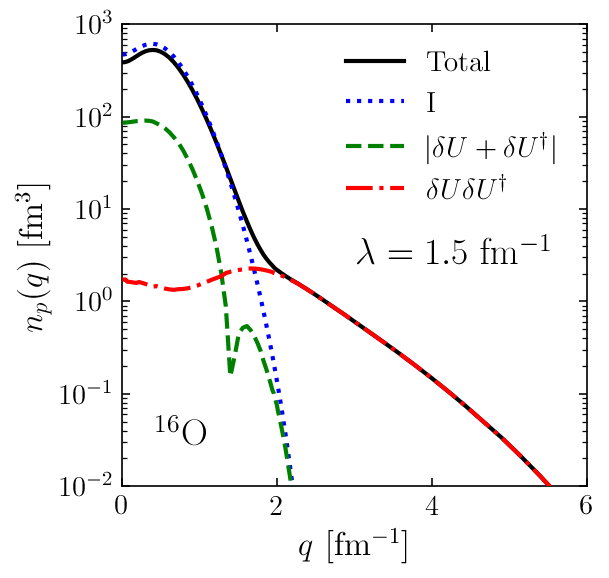

In [9]:
# 16O contributions at \lambda = 1.5 fm^-1
single_nucleon_momentum_distribution_contributions(
    'O16', 'proton', 6, 1.5, y_limits=(1e-2, 1e3), print_normalization=True,
    save=True
)

## $\frac{A}{^{4}\rm{He}}$ ratios

In [10]:
def single_nucleon_momentum_distributions_vary_nucleus(
        nuclei, nucleon, kvnn, lamb, x_limits=(0.0,6.0), y_limits=(-1.0,10.0),
        save=False
):
    """Plots momentum distributions varying the NN potential."""
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))

    # Get 4He denominator
    (q_array, q_weights, n_4he_array, _, _, _, _, _, _) = (
        load_momentum_distribution('He4', nucleon, kvnn, lamb)
    )
    
    # Loop over potentials
    for i, nucleus in enumerate(nuclei):
        
        nucleus_name, Z, N = nucleus

        # Load data from file
        (q_array, q_weights, n_array, _, _, _, _, _, _) = (
            load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb)
        )
        
        ratio_array = n_array / n_4he_array

        # Add to plot
        ax.plot(q_array, ratio_array, label=label_nucleus(nucleus_name),
                linewidth=2.0)

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(r"$A / ^{4}$He ratio", fontsize=16)

    # Set legend
    ax.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.0, loc='upper left',
              fontsize=16)

    # Add kvnn label
    ax.add_artist(
        AnchoredText(label_kvnn(kvnn), loc='upper left',
                     prop=dict(size=18), frameon=False)
    )
    
    # Add \lambda label
    ax.add_artist(
        AnchoredText(label_lambda(lamb), loc='upper right', prop=dict(size=18),
                     frameon=False)
    )
    
    # Save?
    if save:
        file_name = (f"{nucleon}_momentum_distributions_ratios_kvnn_{kvnn}"
                     f"_lamb_{lamb}")
        for nucleus in nuclei:
            nucleus_name, _, _ = nucleus
            file_name += f"_{nucleus_name}"
        file_name = replace_periods(file_name)
        f.savefig(figures_directory + file_name + ".png")

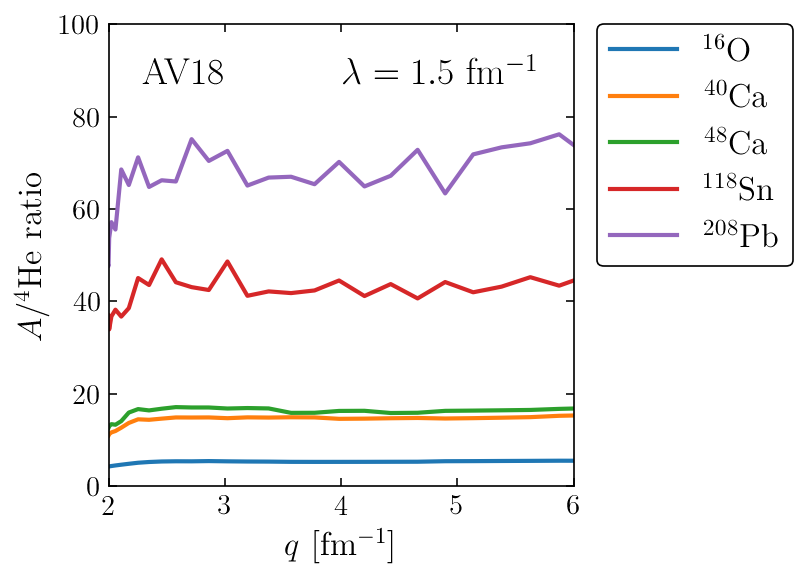

In [11]:
# nuclei = (('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20), ('Ca48', 20, 28),
#           ('Sn118', 50, 68), ('Pb208', 82, 126))
nuclei = (('O16', 8, 8), ('Ca40', 20, 20), ('Ca48', 20, 28), ('Sn118', 50, 68),
          ('Pb208', 82, 126))

single_nucleon_momentum_distributions_vary_nucleus(
    nuclei, 'proton', 6, 1.5, x_limits=(2.0, 6.0), y_limits=(0.0, 100),
    save=True
)

## Vary potential

In [12]:
def single_nucleon_momentum_distributions_vary_kvnn(
        nucleus_name, nucleon, kvnns, lamb, x_limits=(0.0,6.0),
        y_limits=(9e-6,1e3), y_scale='log', legend_fontsize=11, save=False
):
    """Plots momentum distributions varying the NN potential."""
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
    
    # Loop over potentials
    for i, kvnn in enumerate(kvnns):
        
        # Load data from file
        (q_array, q_weights, n_array, _, _, _, _, _, _) = (
            load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb)
        )
    
        # Multiply by factor (2\pi)^3
        n_array *= (2*np.pi) ** 3

        # Add to plot
        if y_scale == 'linear':  # Linear scale
            ax.plot(q_array, n_array * q_array ** 2, label=label_kvnn(kvnn),
                    linewidth=2.0)
        elif y_scale == 'log':  # Log scale
            ax.plot(q_array, n_array, label=label_kvnn(kvnn), linewidth=2.0)

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if y_scale == 'linear' and nucleon == 'proton':
        ylabel = r"$q^2 n_{p}(q)$ [fm]"
    elif y_scale == 'linear' and nucleon == 'neutron':
        ylabel = r"$q^2 n_{n}(q)$ [fm]"
    elif y_scale == 'log' and nucleon == 'proton':
        ylabel = r"$n_{p}(q)$ [fm" + r'$^3$' + ']'
    elif y_scale == 'log' and nucleon == 'neutron':
        ylabel = r"$n_{n}(q)$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=legend_fontsize, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center left',
                     prop=dict(size=18), frameon=False)
    )
    
    # Add \lambda label
    ax.add_artist(
        AnchoredText(label_lambda(lamb), loc='lower left', prop=dict(size=18),
                     frameon=False)
    )
    
    # Save?
    if save:
        file_name = f"{nucleus_name}_{nucleon}_momentum_distributions_kvnns"
        for kvnn in kvnns:
            file_name += f"_{kvnn}"
        file_name += f"_lamb_{lamb}_{y_scale}_scale"
        file_name = replace_periods(file_name)
        f.savefig(figures_directory + file_name + ".png")

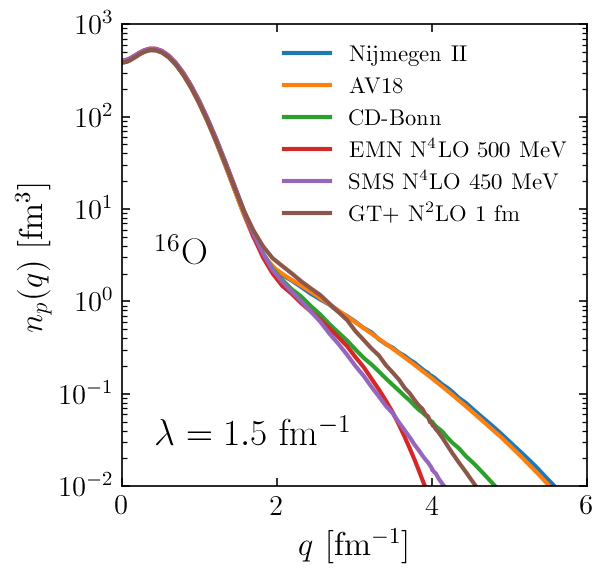

In [13]:
single_nucleon_momentum_distributions_vary_kvnn(
    'O16', 'proton', (5, 6, 7, 79, 111, 222), 1.5, y_limits=(1e-2,1e3),
    save=True
)

## Vary $\lambda$

In [44]:
# TODO: Make sure q_array are the same between each n(q)
# Add more points at low q
def single_nucleon_momentum_distributions_vary_lambda(
        nucleus_name, nucleon, kvnn, lamb, lamb_min=1.35, lamb_max=6.0,
        x_limits=(0.0,6.0), y_limits=(9e-6,1e3), y_scale='log',
        nucleus_label=False, legend=False, save=False
):
    """Plots momentum distributions varying the SRG flow parameter \lambda."""
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
        
    # Create light red band from minimum \lambda to maximum \lambda
    (q_lmin_array, _, n_lmin_array, _, _, _, _, _, _) = (
        load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb_min)
    )
    n_lmin_array *= (2*np.pi) ** 3  # Same scale as VMC
    
    (q_lmax_array, _, n_lmax_array, _, _, _, _, _, _) = (
        load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb_max)
    )
    n_lmax_array *= (2*np.pi) ** 3  # Same scale as VMC
    
    # Input \lambda and IPM
    (q_array, q_weights, n_array, _, n_ipm_array, _, _, _, _) = (
        load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb)
    )
    n_array *= (2*np.pi) ** 3  # Same scale as VMC
    n_ipm_array *= (2*np.pi) ** 3
    
    # Add curves to plot
    if y_scale == 'linear':
        
        # Light red band
        ax.fill_between(
            q_lmin_array, y1=n_lmax_array * q_lmin_array ** 2,
            y2=n_lmin_array * q_lmin_array ** 2, color='red', alpha=0.15
        )
        # IPM
        ax.plot(q_array, n_ipm_array * q_array ** 2, color='black',
                label=label_lambda(np.inf), ls='dotted', lw=2.0)
        # SRG
        ax.plot(q_array, n_array * q_array ** 2, color='red',
                label=label_lambda(lamb), lw=2.0)
        
    elif y_scale == 'log':
        
        # Light red band
        ax.fill_between(q_lmin_array, y1=n_lmax_array, y2=n_lmin_array, color='red',
                        alpha=0.15)
        # IPM
        ax.plot(q_array, n_ipm_array, color='black', label=label_lambda(np.inf),
                ls='dotted', lw=2.0)
        # SRG
        ax.plot(q_array, n_array, color='red', label=label_lambda(lamb), lw=2.0)

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if y_scale == 'linear' and nucleon == 'proton':
        ylabel = r"$q^2 n_{p}(q)$ [fm]"
    elif y_scale == 'linear' and nucleon == 'neutron':
        ylabel = r"$q^2 n_{n}(q)$ [fm]"
    elif y_scale == 'log' and nucleon == 'proton':
        ylabel = r"$n_{p}(q)$ [fm" + r'$^3$' + ']'
    elif y_scale == 'log' and nucleon == 'neutron':
        ylabel = r"$n_{n}(q)$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    if legend:
        ax.legend(loc='upper right', fontsize=16, frameon=False)

    # Add nucleus label
    if nucleus_label:
        ax.add_artist(
            AnchoredText(label_nucleus(nucleus_name), loc='upper right',
                         prop=dict(size=18), frameon=False)
        )
    
    # Save?
    if save:
        file_name = (f"{nucleus_name}_{nucleon}_momentum_distributions_kvnn"
                     f"_{kvnn}_vary_lambda_{lamb}_{y_scale}_scale")
        file_name = replace_periods(file_name)
        f.savefig(figures_directory + file_name + ".png")

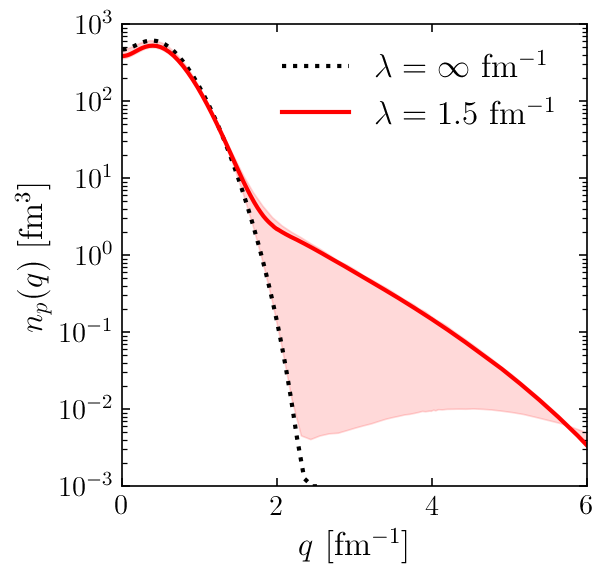

In [45]:
single_nucleon_momentum_distributions_vary_lambda(
    'O16', 'proton', 6, 1.5, y_limits=(1e-3, 1e3), legend=True, save=True)

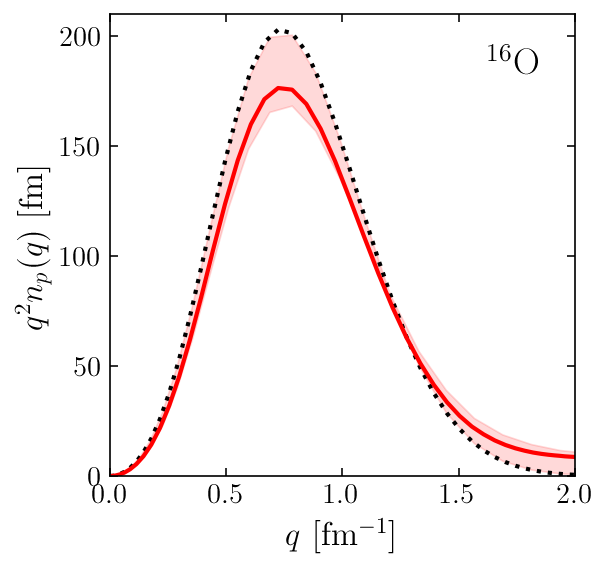

In [46]:
single_nucleon_momentum_distributions_vary_lambda(
    'O16', 'proton', 6, 1.5, x_limits=(0.0, 2.0), y_limits=(-0.1, 210.0),
    y_scale='linear', nucleus_label=True, save=True
)

## Matching interactions

In [ ]:
# Do a figure that compares two potentials using matching transformations
# Will need data for this
# ...

In [ ]:
# ...